In [1]:
library(tidyverse)
library(dplyr)
library(repr)
library(tidymodels)
library(recipes)
install.packages("themis")
library(themis)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

## Introduction

- Wine quality highly depends on its composition of various aromatic compounds. By assessing the content of wines such as their sugar content and pH value, we will be able to determine how good the wine is. 
- In this project, we will be using the wine quality dataset obtained from a web URL.
- We want to solve **regression problem** —- what would be the wine’s quality level given its values on the fixed acidity, volatile acidity, and other variables.
-  7 out of the 12 variables are used to predict the **wine quality**, which ranges from 0 to 10, with 10 being the highest quality wine.
- We focus on indicating which attributes affect the wine quality and predicting the quality based on each attribute's values. By using the regression method, we create a linear formula and use the coefficients to know how the attribute level influences the wine quality(i.e. it positively/negatively influences the wine quality).

## Preliminary exploratory data analysis

**1. Data Reading**

In [2]:
temp <- tempfile()
download_file <- download.file("https://archive.ics.uci.edu/static/public/186/wine+quality.zip", temp)
red_wine <- read.csv2(unz(temp, "winequality-red.csv")) |>
             mutate(type = 0)
white_wine <- read.csv2(unz(temp, "winequality-white.csv")) |>
              mutate(type = 1)
unlink(temp)

**2. Data Wrangling**

In [3]:
wine_data <- rbind(red_wine, white_wine) |>
             mutate(across(fixed.acidity:alcohol, as.numeric), type = as_factor(type), quality = as.factor(ifelse(quality < 5, "Low", "High")))

write_csv(wine_data, "../data/wine_data.csv")
head(wine_data)

fixed.acidity volatile.acidity citric.acid residual.sugar chlorides
1  7.4          0.70             0.00        1.9            0.076    
2  7.8          0.88             0.00        2.6            0.098    
3  7.8          0.76             0.04        2.3            0.092    
4 11.2          0.28             0.56        1.9            0.075    
5  7.4          0.70             0.00        1.9            0.076    
6  7.4          0.66             0.00        1.8            0.075    
  free.sulfur.dioxide total.sulfur.dioxide density pH   sulphates alcohol
1 11                  34                   0.9978  3.51 0.56      9.4    
2 25                  67                   0.9968  3.20 0.68      9.8    
3 15                  54                   0.9970  3.26 0.65      9.8    
4 17                  60                   0.9980  3.16 0.58      9.8    
5 11                  34                   0.9978  3.51 0.56      9.4    
6 13                  40                   0.9978  3.51 0.56      9.4    
  quality type
1 High    0   
2 High    0   
3 High    0   
4 High    0   
5 High    0   
6 High    0

**3. Data Splitting**

To know how good our prediction is, we should split our data into training dataset and testing dataset.

In [4]:
set.seed(2000)
wine_split <- initial_split(wine_data, prop = 0.75, strata = quality)
wine_training <- training(wine_split)
wine_testing <- testing(wine_split)

**4. Summarization**

**a. The number of observations in each red wine/white wine class**

In [5]:
wine_type_number <- wine_training |>
                    group_by(type) |>
                    summarize(Number = n())
wine_type_number

type Number
1 0    1197  
2 1    3675

- We have 4898 observations for White wine and 1599 observations for Red wine.
- There is an imbalance between the types of the wine. 

**b. The number of observations for each quality level.**

In [6]:
quality_number <- wine_training |>
                  group_by(quality) |>
                  summarize(Number = n())
quality_number

quality Number
1 High    4698  
2 Low      174

#### Fixing the imbalance of the data

In [7]:
wine_recipe <- recipe(quality ~ ., wine_training) |>
                step_upsample(quality, over_ratio = 1, skip = FALSE) |>
                prep()

wine_training <- bake(wine_recipe, wine_training)

quality_number <- wine_training |>
                  group_by(quality) |>
                  summarize(Number = n())
quality_number

quality Number
1 High    4698  
2 Low     4698

**c. Mean value of each measurements for different quality type.**

In [8]:
mean_measurements <- wine_training |>
                     group_by(quality) |>
                     summarize(mean_fixed_acidity = mean(fixed.acidity),
                               mean_volatile_acidity = mean(volatile.acidity),
                               mean_citric_acid = mean(citric.acid),
                               mean_residual_sugar = mean(residual.sugar),
                               mean_chlorides = mean(chlorides),
                               mean_free_sufdioxide = mean(free.sulfur.dioxide),
                               mean_tot_sufdioxide = mean(total.sulfur.dioxide),
                               mean_density = mean(density),
                               mean_ph = mean(pH),
                               mean_sulphates = mean(sulphates),
                               mean_alcohol = mean(alcohol))
mean_measurements

quality mean_fixed_acidity mean_volatile_acidity mean_citric_acid
1 High    7.218029           0.3338559             0.3222435       
2 Low     7.446786           0.4705481             0.2779097       
  mean_residual_sugar mean_chlorides mean_free_sufdioxide mean_tot_sufdioxide
1 5.479438            0.05562857     30.89166             116.3789           
2 4.231716            0.06138144     22.96871             106.1924           
  mean_density mean_ph  mean_sulphates mean_alcohol
1 0.9946849    3.218540 0.5321605      10.50531    
2 0.9950686    3.243736 0.5165858      10.23266

The ranges of the mean are different across different columns hence the variables will need to be scaled  

**d. Missing data - We have no missing data in this dataset.**

**4. Visualization: histogram between quality and other numeric variables**

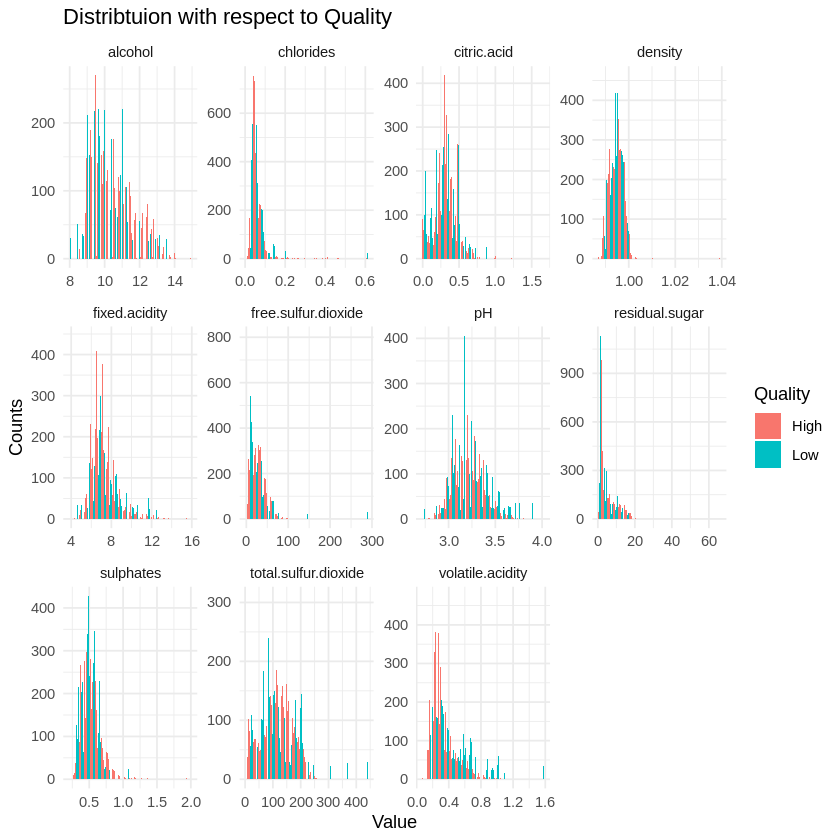

In [9]:
#Gather data for facetting
gathered_data <- wine_training |>
  gather(key = "variable", value = "value", -c("quality", "type"))

# Create facetted histograms
facet_histograms <- ggplot(gathered_data, aes(x = value, fill = quality)) +
  geom_histogram(position = "dodge", bins = 100) +
  labs(title = "Distribtuion with respect to Quality", x = "Value", y = "Counts", fill = "Quality") +
  facet_wrap(~variable, scales = "free") +
  theme_minimal()

# Display facetted histograms
print(facet_histograms)

## Choosing predictors

In [10]:
wine_training <- wine_training |>
                 select(alcohol, volatile.acidity, density, alcohol, quality)   

## Training & Evaluation

### 1. The multivariable Linear regression Model

In [11]:
# set.seed(1)
# wine_data_reg <- wine_training |>
#                   mutate(quality = as.numeric(quality)) |>
#                   select(alcohol, density, volatile.acidity, quality)
# head(wine_data_reg)

In [12]:
# lm_recipe <- recipe(quality ~ .,
#                      data = wine_data_reg)

# lm_spec <- linear_reg() |>
#    set_engine("lm") |>
#    set_mode("regression")

# lm_fit <- workflow() |>
#    add_recipe(lm_recipe) |>
#    add_model(lm_spec) |>
#    fit(data = wine_data_reg)

#  lm_fit

In [13]:
# lm_test_results <- lm_fit |>
#                    predict(wine_testing) |>
#                    bind_cols(wine_testing) |>
#                    mutate(quality = ifelse(quality <= 5, "Low", "High"), .pred = ifelse(.pred <= 5, "Low", "High"))|>
#                    mutate(quality = as.factor(quality), .pred = as.factor(.pred)) |>
#                    metrics(truth = quality, estimate = .pred) |>
#                    filter(.metric == "accuracy")

# lm_test_results
    

# lm_coeffs <- lm_fit |>
#               extract_fit_parsnip() |>
#               tidy()
#  lm_coeffs

The RMSPE of this linear regression model is 0.7961641

The mathematical expression to describe this linear regression model is:
$quality = 3.81887647 + 0.09180436 \cdot (fixed.acidity) - 0.19801129 \cdot (volatile.acidity) + 0.01694675 \cdot (citric.acid) - 0.08928023 \cdot (chlorides) - 0.08928023 \cdot (density) + 0.07583322 \cdot (pH) + 0.13697853 \cdot (sulphates)$

### 2. Classification Model

In [14]:
# Create a recipe
knn_recipe <- recipe(quality ~ ., data = wine_training) |>
              step_scale(all_predictors()) |>
              step_center(all_predictors())

In [15]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

In [16]:
wine_vfold <- vfold_cv(wine_training, v = 5, strata = quality)

In [17]:
gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 10))

In [18]:
knn_fit <- workflow() |>
                add_recipe(knn_recipe) |>
                add_model(knn_spec) |>
                tune_grid(resamples = wine_vfold, grid = gridvals) 

In [19]:
knn_eval_rst <- knn_fit |>
                collect_metrics() |>
                filter(.metric == "accuracy")

top_5_neighbor <-  knn_eval_rst |>
                   slice_max(order_by = mean, n = 5)

top_5_neighbor

neighbors .metric  .estimator mean      n std_err     .config              
1  1        accuracy binary     0.9804177 5 0.001203966 Preprocessor1_Model01
2 11        accuracy binary     0.9050657 5 0.002655978 Preprocessor1_Model02
3 21        accuracy binary     0.8413161 5 0.002091590 Preprocessor1_Model03
4 31        accuracy binary     0.7872488 5 0.003260569 Preprocessor1_Model04
5 41        accuracy binary     0.7548937 5 0.002786582 Preprocessor1_Model05

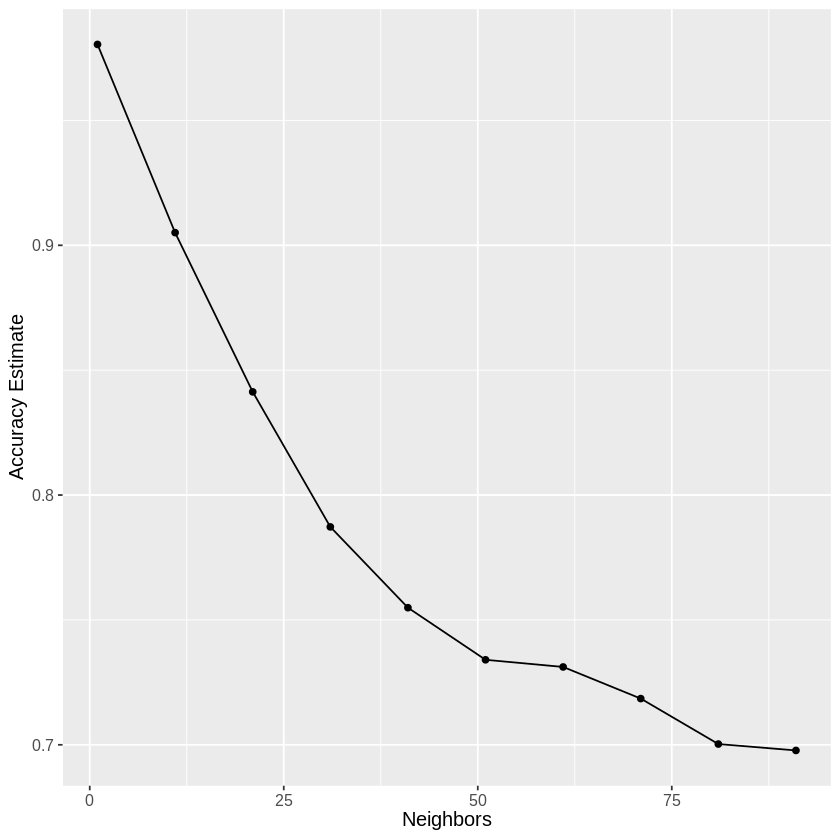

In [20]:
accuracy_vs_k <- ggplot(knn_eval_rst, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

In [21]:
best_k <- knn_fit |>
          select_best("accuracy") |>
          pull(neighbors) 
best_k

[1] 1

In [22]:
knn_spec_final <- knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
                  set_engine("kknn") |>
                  set_mode("classification")

In [23]:
knn_fit_final <- workflow() |>
                add_recipe(knn_recipe) |>
                add_model(knn_spec_final) |>
                fit(data = wine_training)

In [24]:
knn_pred <- predict(knn_fit_final, wine_testing) |>
            bind_cols(wine_testing)

In [25]:
testing_rst <- metrics(knn_pred, truth = quality, estimate = .pred_class) |>
               filter(.metric == "accuracy")

testing_rst

.metric  .estimator .estimate
1 accuracy binary     0.9372308

The accuracy observed in this classification model is 0.9329231.

In [26]:
confusion <- knn_pred |>
             conf_mat(truth = quality, estimate = .pred_class)
confusion

          Truth
Prediction High  Low
      High 1510   59
      Low    43   13

In [30]:
recall_score <- knn_pred |>
  recall(truth = quality, estimate = .pred_class, event_level = "first")
recall_score

.metric .estimator .estimate
1 recall  binary     0.9723117

In [31]:
precision_score <- knn_pred |>
  precision(truth = quality, estimate = .pred_class, event_level = "first")
precision_score

.metric   .estimator .estimate
1 precision binary     0.9623964

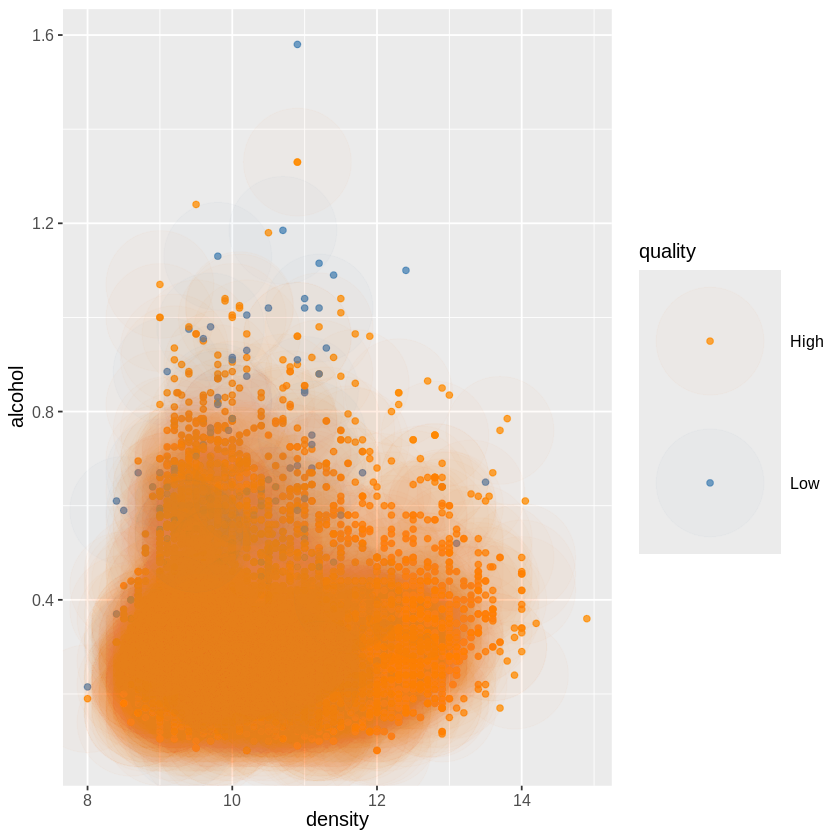

In [38]:
wkflw_plot <-
  ggplot() +
  geom_point(data = wine_data,
             mapping = aes(x = alcohol,
                           y = volatile.acidity,
                           color = quality),
             alpha = 0.75) +
   geom_point(data = knn_pred,
             mapping = aes(x = alcohol,
                           y = volatile.acidity,
                           color = quality),
             alpha = 0.02,
             size = 30) +
  labs(color = "quality",
       x = "density",
       y = "alcohol") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

wkflw_plot

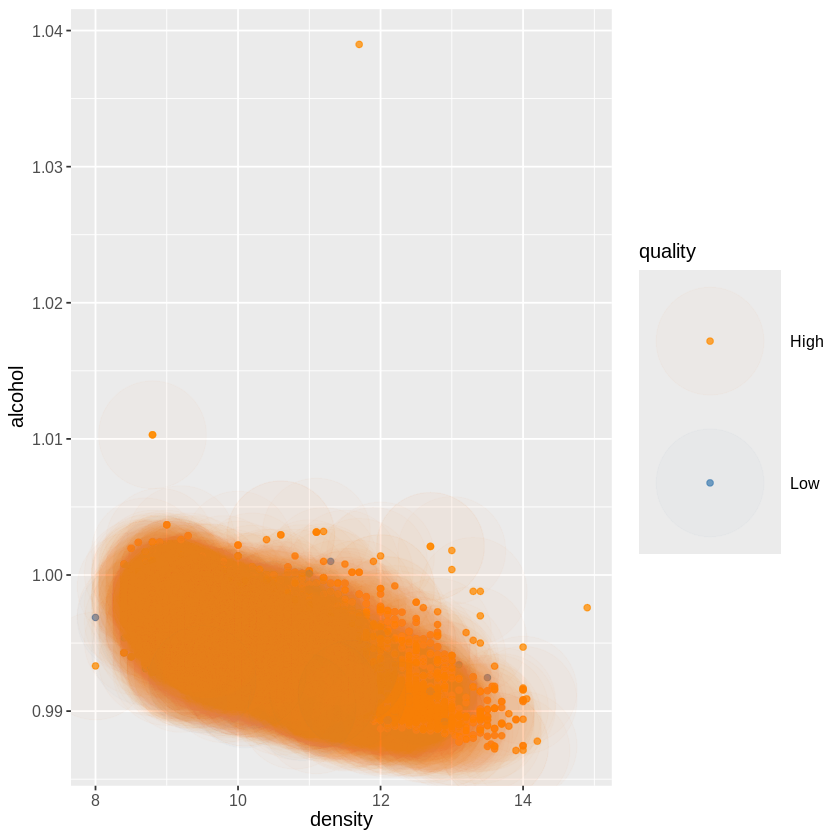

In [40]:
wkflw_plot <-
  ggplot() +
  geom_point(data = wine_data,
             mapping = aes(x = alcohol,
                           y = density,
                           color = quality),
             alpha = 0.75) +
   geom_point(data = knn_pred,
             mapping = aes(x = alcohol,
                           y = density,
                           color = quality),
             alpha = 0.02,
             size = 30) +
  labs(color = "quality",
       x = "density",
       y = "alcohol") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

wkflw_plot

## Methods

- After data reading and wrangling, we used all 12 variables for preliminary data summarization and visualization. We then compared the number of observations in each red/ white wine class, the number of observations in each quality level for red and white wine respectively, and the mean value of each feature for each quality level. 

- Multi-histogram is used to visualize the relationship between each variable and the wine quality, each with one predictor on the x axis, counts on the y axis, and color indicating the different quality levels. If each quality level tends to show up on a certain value of the x axis, we can conclude that there is linear correlation between the wine quality and that predictor. Otherwise, there is no correlation or non-linear correlation. 

- **We will only use 7 numeric variables excluding type total.sulfur.dioxide, free.sulfur.dioxide, residual sugar and alcohol** 

## Expected outcomes and significance

- Due to class imbalance in the categories of the target column (quality): some of the categories are missing. We expect the model will be less precise for the level from 0 to 2 and the level 10.
- However, we hope the model will be able to predict correctly the quality from 3 - 8

- These findings will allow a more efficient and more systematic wine quality assessment as we will be able assess the quality of the wines not only by its age or individual tastes, but also the actual content in the wine itself.
-  The findings can also lead to further discoveries such as how different environments in which the grapes grew in would affect the quality of the wines, in which they can be used to optimize the wine development.
